# Starter Stuff

## Imports

In [1]:
import numpy as np
import scipy.ndimage
from skimage import data, io, color, filters, morphology, util, measure
from skimage.io import imsave
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
from PIL import Image
from scipy import ndimage
import cv2
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import os
import re
import deepcell
import tensorflow as tf


2022-05-21 15:57:51.721617: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Checking Versions and Conda Env

In [3]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.__file__)

3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


## Define Functions

In [2]:
def showtif(file, zstack=0, channel=0, verbose = False):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack,channel]
    if verbose==True:
        print(skimg.shape,"\n", "Showing Z-stack {} of {}".format(zstack+1, skimg.shape[0]))
    plt.axis('off')
    a = plt.imshow(img,cmap='gray')
    return a

## Set Paths

In [5]:
SCRIPTDIR = os.path.realpath('./')
# SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'

os.chdir(SCRIPTDIR)
os.chdir('../output/Mesmer/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../models/')
MODELDIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/MesmerCellTracking')
OUTDIR = os.getcwd()
# os.listdir()

FileNotFoundError: [Errno 2] No such file or directory: '../output/MesmerCellTracking'

# Testing the Pieces

## Bring in Data

In [5]:
#Move through DATADIR and pull only the files that are nuclear images
os.chdir(DATADIR)
nucimgs = []
for item in os.listdir():
    match = re.search("Nuc",item)
    if match:
        nucimgs.append(item)

# nucimgs

## Define a single image to use

(23, 1024, 1024) 
 Showing Z-stack 1 of 23


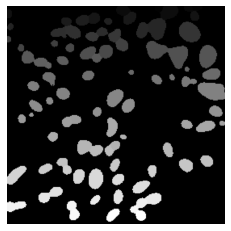

In [6]:

tif = io.imread(nucimgs[0], plugin='tifffile')
label = tif[:,:,:,0]
nuc = tif[:,:,:,1]
showtif(label, verbose=True)


In [7]:
label = np.expand_dims(label,axis=-1)
nuc = np.expand_dims(nuc,axis=-1)
print("label shape:",label.shape)
print("nuc shape:",label.shape)

label shape: (23, 1024, 1024, 1)
nuc shape: (23, 1024, 1024, 1)


## Running the function
<https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#celltracking>

In [8]:
import deepcell.applications.cell_tracking
labeldict = deepcell.applications.cell_tracking.CellTracking().predict(nuc,label)

2022-04-24 15:19:22.025035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ext3/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-04-24 15:19:22.025059: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-24 15:19:22.025078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cl001.hpc.nyu.edu): /proc/driver/nvidia/version does not exist
2022-04-24 15:19:22.025275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

2022-04-24 15:19:32.124383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-24 15:19:32.125111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


## Exploring the Output

### Visualizing the Results

In [9]:
labeldict.keys()

dict_keys(['tracks', 'X', 'y', 'y_tracked'])

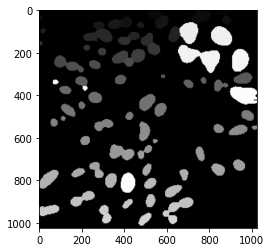

In [10]:
labeldict['y_tracked'][2]
plt.imshow(labeldict['y_tracked'][2],cmap='gray')

In [11]:
labeldict['y_tracked'].shape

(23, 1024, 1024, 1)

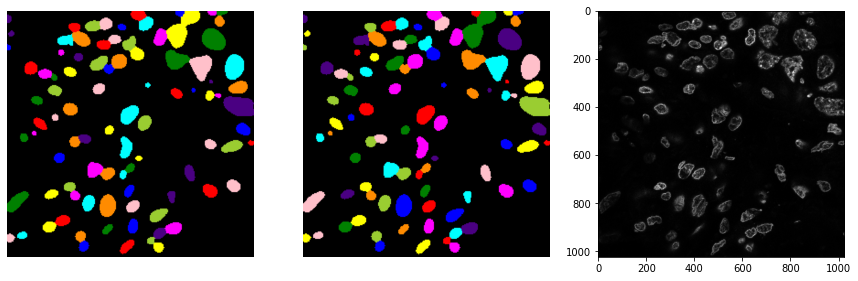

In [12]:
teststack = 1
labels = measure.label(labeldict['y_tracked'][teststack,...,0])
label_overlay = color.label2rgb(labels, bg_label = 0)
origlabels = label[teststack,...,0].copy()
orig_overlay = color.label2rgb(origlabels, bg_label = 0)
labeltest = nuc[teststack,...,0].copy()

plt.figure(figsize=(15,12))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(label_overlay)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(orig_overlay)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(labeltest, cmap='gray')

In [13]:
len(labeldict['tracks'])

434

### Make a gif

In [14]:
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video
HTML(get_js_video(np.expand_dims(nuc, axis=0),
                  batch=0, cmap='gray'))


In [15]:
HTML(get_js_video(np.expand_dims(labeldict['y_tracked'], axis=0),
                  batch=0, cmap='cubehelix', vmin=0, vmax=len(labeldict['tracks'])))

### Making a Volumetric Projected Image
 - At the bottom of this notebook: <https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/training/panopticnets/3D%20Nuclear%20Segmentation%20-%20Deep%20Watershed.ipynb>

In [23]:
projectarea = labeldict['y_tracked'].copy()
projectxydims = 250

x_min = np.random.randint(0,projectarea.shape[1]-projectxydims)
x_max = x_min + projectxydims
y_min = np.random.randint(0,projectarea.shape[2]-projectxydims)
y_max = y_min + projectxydims
z_min = 0
z_max = projectarea.shape[0] + z_min
masks = projectarea[z_min:z_max, x_min:x_max, y_min:y_max]
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)

colors = np.empty(plot_masks.shape, dtype='<U9')
color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None
    color_dict[label] = color
    colors = np.where(plot_masks==label, color, colors)

print(plot_masks.shape)
print(y_max)
print(x_max)


(250, 250, 23)
337
660


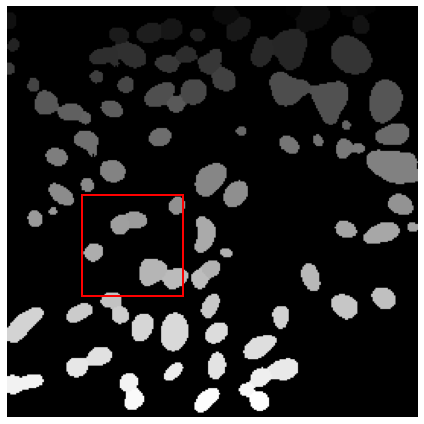

In [21]:
import matplotlib.patches as mpatches

# draw rectangle around segmented coins
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(projectarea[0], cmap='gray')

rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

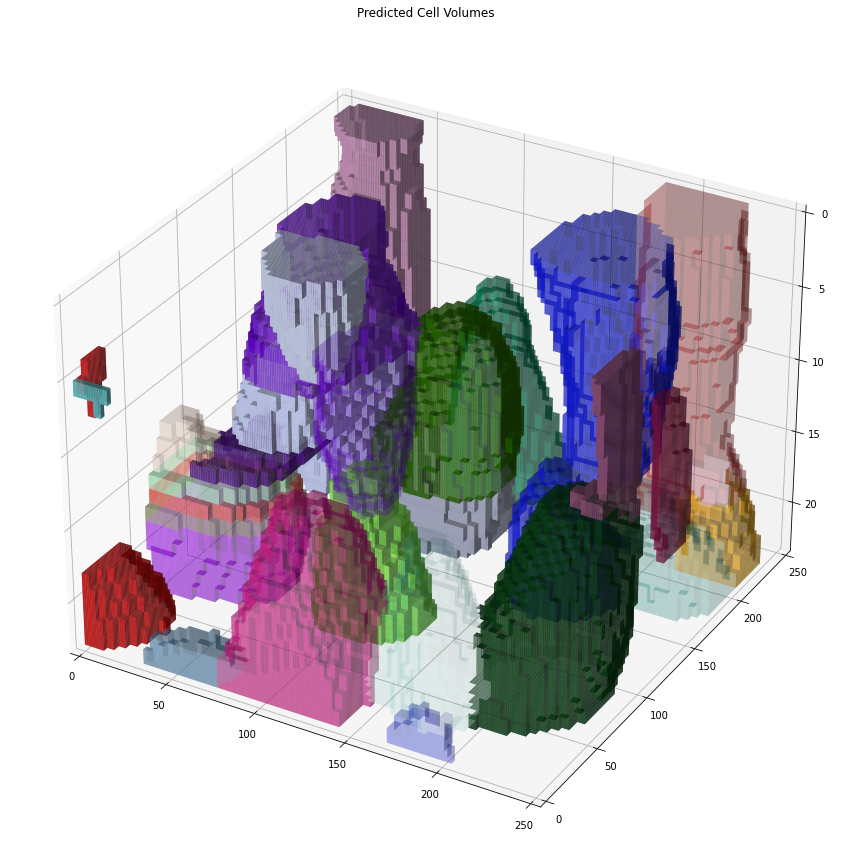

--- 219.0 seconds ---


In [22]:
start_time = time.time()

fig = plt.figure(figsize=(15, 25))

# Predicted Cell volumes
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, projectxydims)
ax.set_ylim3d(0, projectxydims)
ax.set_zlim3d(z_max, z_min)

ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Predicted Cell Volumes')
plt.show()
print("--- %s seconds ---" % round((time.time() - start_time),0))

# TODO
 - Save the gifs
 - Apply the cell tracking to the Mesmer script